In [1]:
## 2020-01-30
## Mikko Tukiainen

## 2020-02-15
## Joni Juvonen
## Added fake classes

In [15]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
SEED = 2020
NUM_FOLDS = 5
TRAIN_PCT = 0.85
KEEP_COLS = ['index', 'label', 'split', 'isVal', 'cv_fold', 'person_count',
             'first_person_label','second_person_label','first_person_frame_labels',
             'second_person_frame_labels','original', 'version']

In [3]:
## Open previously generated train-val split metadata file
meta = pd.read_csv('../data/metadata_tr_val_split.csv')[['index','label','person_count','original']]
orig_len = len(meta)
meta.head()

,index,label,person_count,original
0,rfpjvmqzre.mp4,FAKE,0,jcdwcvhiic.mp4
1,icwlmhflzf.mp4,FAKE,0,bmrwcqrpyp.mp4
2,zginlpggsb.mp4,FAKE,0,roqgtismye.mp4
3,uwsqssxxtw.mp4,FAKE,0,rvkabkpqvw.mp4
4,mvuiapsmya.mp4,FAKE,1,rxnrnlmipx.mp4


In [4]:
## Open actor face cluster metafile 
## generated in https://www.kaggle.com/hmendonca/proper-clustering-with-facenet-embeddings-eda/output (version 17)
clusters = pd.read_csv('../data/face_clusters_combined.csv')
clusters['original'] = clusters['video'] 

clusters["both_missing"] =clusters['cluster_1'].isna()&clusters['cluster_2'].isna()
    
clusters.head()

,video,cluster_1,cluster_2,original,both_missing
0,bmrwcqrpyp.mp4,0.0,NaN,bmrwcqrpyp.mp4,False
1,jkdehoarcj.mp4,0.0,NaN,jkdehoarcj.mp4,False
2,aywpqylxdm.mp4,NaN,NaN,aywpqylxdm.mp4,True
3,nvirvscqzx.mp4,1.0,0.0,nvirvscqzx.mp4,False
4,sjtuoasekc.mp4,0.0,NaN,sjtuoasekc.mp4,False


In [5]:
# check originals
clusters[clusters['original'].isna()].head()

,video,cluster_1,cluster_2,original,both_missing


The originals are not included in the clusters dataframe.

In [6]:
cluster_ids, cluster_counts = np.unique(np.concatenate([clusters.cluster_1.dropna().values,
                                       clusters.cluster_2.dropna().values]), return_counts=True)
#sort
cluster_counts, cluster_ids = zip(*sorted(zip(cluster_counts.tolist(), cluster_ids.tolist()),reverse=True))
cluster_ids = list(cluster_ids)

print("Number of unique clusters {0}".format(len(cluster_ids)))
for i, (c, count) in enumerate(zip(cluster_ids, cluster_counts)):
    print("Cluster id {0}: {1} original videos".format(int(c),count))
    if i >= 10:
        break

Number of unique clusters 646
Cluster id 2: 151 original videos
Cluster id 224: 123 original videos
Cluster id 79: 110 original videos
Cluster id 297: 106 original videos
Cluster id 211: 105 original videos
Cluster id 275: 100 original videos
Cluster id 217: 100 original videos
Cluster id 64: 96 original videos
Cluster id 247: 95 original videos
Cluster id 154: 95 original videos
Cluster id 137: 90 original videos


In [7]:
## Merge data
meta_tmp = meta.sample(frac=1, random_state=SEED)
meta_tmp = meta_tmp.merge(clusters[['original','cluster_1','cluster_2', 'both_missing']].drop_duplicates(), 
                          on='original', how='left')

Add clusters to the original videos. Clusters are the same in any of their fake replicates so just copy the clusters from the first one. 

In [8]:
for original_index in tqdm(meta_tmp[meta_tmp['original'].isna()].index.values):
    original_video = meta_tmp.loc[original_index,'index']
    
    # get fake replicates
    fakes = meta_tmp[meta_tmp['original'] == original_video]
    if len(fakes) > 0:
        cluster_1 = fakes.iloc[0]['cluster_1']
        cluster_2 = fakes.iloc[0]['cluster_2']
        both_missing = fakes.iloc[0]['both_missing']
        
        # set the same clusters to the original
        meta_tmp.at[original_index,'cluster_1'] = cluster_1
        meta_tmp.at[original_index,'cluster_2'] = cluster_2
        meta_tmp.at[original_index,'both_missing'] = both_missing

In [9]:
meta_tmp[meta_tmp['original'].isna()].head()

,index,label,person_count,original,cluster_1,cluster_2,both_missing
2,smptxlklxc.mp4,REAL,1,NaN,586.0,NaN,False
25,sacjkenugu.mp4,REAL,1,NaN,354.0,NaN,False
27,mquozjaiiw.mp4,REAL,1,NaN,578.0,NaN,False
37,ueqbcbqpep.mp4,REAL,1,NaN,49.0,NaN,False
46,xyvvgbdwde.mp4,REAL,1,NaN,556.0,NaN,False


In [10]:
## Open fake types and merge columns
fake_types_df = pd.read_csv('../data/fake_type_classes.csv')
meta_tmp = meta_tmp.merge(fake_types_df[['index','first_person_label', 'second_person_label']], on='index')
meta_tmp.head()

,index,label,person_count,original,cluster_1,cluster_2,both_missing,first_person_label,second_person_label
0,gmuagvvcen.mp4,FAKE,1,xyioxposka.mp4,633.0,NaN,False,3.0,NaN
1,nlbejgudfx.mp4,FAKE,1,acguxjvmju.mp4,539.0,NaN,False,3.0,NaN
2,smptxlklxc.mp4,REAL,1,NaN,586.0,NaN,False,0.0,NaN
3,xmodyeeaxr.mp4,FAKE,1,ptpwappdyx.mp4,130.0,NaN,False,1.0,NaN
4,hvxrsfgvyi.mp4,FAKE,2,qelncdmypn.mp4,404.0,79.0,False,2.0,1.0


In [11]:
## To make sure there is no leak between videos related to the original and same actors
## we generate a grouper column based on the original video and, in case former is missing, the actor cluster
## the video belongs to

## If cluster_1 exist choose it, else "Y"
meta_tmp['name_index'] = np.where(meta_tmp.cluster_1.notna(),
                                  meta_tmp.cluster_1.astype(str),
                                  "Y")
meta_tmp['name_index'] = meta_tmp.name_index.astype(str)
meta_tmp.head()

,index,label,person_count,original,cluster_1,cluster_2,both_missing,first_person_label,second_person_label,name_index
0,gmuagvvcen.mp4,FAKE,1,xyioxposka.mp4,633.0,NaN,False,3.0,NaN,633.0
1,nlbejgudfx.mp4,FAKE,1,acguxjvmju.mp4,539.0,NaN,False,3.0,NaN,539.0
2,smptxlklxc.mp4,REAL,1,NaN,586.0,NaN,False,0.0,NaN,586.0
3,xmodyeeaxr.mp4,FAKE,1,ptpwappdyx.mp4,130.0,NaN,False,1.0,NaN,130.0
4,hvxrsfgvyi.mp4,FAKE,2,qelncdmypn.mp4,404.0,79.0,False,2.0,1.0,404.0


In [12]:
name_counts = meta_tmp.name_index.value_counts()
name_counts

137.0    2255
46.0     1663
64.0     1607
97.0     1345
17.0     1334
         ... 
178.0       2
441.0       2
387.0       2
565.0       2
370.0       2
Name: name_index, Length: 572, dtype: int64

In [14]:
# How many error cases?
name_counts['Y']

429

Text(0, 0.5, 'Number of clusters')

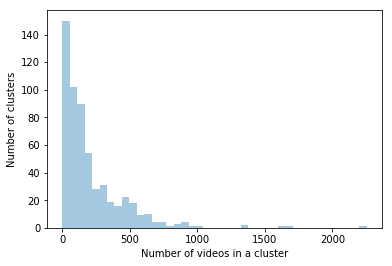

In [21]:
sns.distplot(name_counts.values, kde=False)
plt.xlabel('Number of videos in a cluster')
plt.ylabel('Number of clusters')

A few of the clusters have over 1K videos but majority has less than 200. The smallest number of videos per cluster is two which means one real and one corresponding fake video.

We want to split these clusters first, into train and validation sets. It would be ideal to have sn equal amount of each fake classes in the valdation part.

In [29]:
cluster_info = pd.DataFrame({'cluster':name_counts.keys(), 
                             'count':list(name_counts.values),
                             'type-0':0,
                             'type-1':0,
                             'type-2':0,
                             'type-3':0,
                             'type-4':0})
for i in tqdm(cluster_info.index.values):
    c = cluster_info.iloc[i]['cluster']
    sample = meta_tmp[meta_tmp['name_index'] == c]
    for faketype in range(5):
        cluster_info.at[i,'type-{0}'.format(faketype)] = len(sample[sample['first_person_label'] == float(faketype)])

cluster_info.head()

,cluster,count,type-0,type-1,type-2,type-3,type-4
0,137.0,2255,104,525,1597,28,1
1,46.0,1663,87,198,1061,278,39
2,64.0,1607,96,72,1194,201,44
3,97.0,1345,77,93,687,472,16
4,17.0,1334,86,477,638,118,15


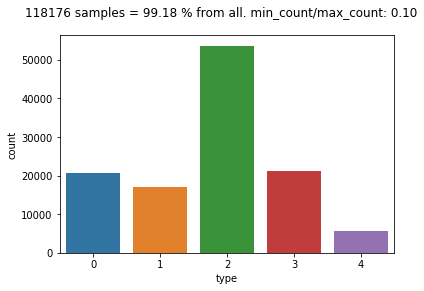

In [69]:
def plotTypeDistribution(clusters=[], return_only_values=False):
    df = pd.DataFrame({'type':[0,1,2,3,4],'count':[0,0,0,0,0]})
    for cluster in clusters:
        sample = cluster_info[cluster_info['cluster']==cluster]
        for faketype in range(5):
            df.at[faketype,'count'] = df.at[faketype,'count'] + sample['type-{0}'.format(faketype)]
    # calculate percentage from the total set
    sample_count = 0
    for faketype in range(5):
        sample_count += df.at[faketype,'count']
    min_count = min(df['count'].values)
    max_count = max(df['count'].values)
    min_max_ratio = min_count/max_count
    percentage = sample_count/len(meta_tmp)
    if return_only_values:
        return percentage, min_max_ratio
    sns.barplot(x='type',y='count',data=df)
    plt.suptitle('{0} samples = {1:.2f} % from all. min_count/max_count: {2:.2f}'.format(sample_count, 
                                                                                         100*percentage,
                                                                                         min_max_ratio))
    plt.show()
    
# plot distribution from all
plotTypeDistribution(name_counts.keys())

Type 2 is the most common and type 4 the least common with overr ten times the difference between these two classes.

For validation set, sample from medium size clusters (40-200 videos) so that all classes are equally represented.

In [104]:
from itertools import permutations
import random

min_val_ratio = 1.0 - TRAIN_PCT - 0.02
max_val_ratio = 1.0 - TRAIN_PCT + 0.02
print("Accept val set size from {0:.2f} to {1:.2f}".format(min_val_ratio,max_val_ratio))

highest_min_max_ratio = 0
validation_index_list = []
stopping_condition = 0.3

# brute force search for suitable combination
range_list = list(range(200,460))
random.shuffle(range_list)
for combination in tqdm(permutations(range_list, 160)):
    percentage, min_max_ratio = plotTypeDistribution(name_counts.keys()[list(combination)], return_only_values=True)
    if percentage > min_val_ratio and percentage < max_val_ratio:
        if min_max_ratio > highest_min_max_ratio:
            highest_min_max_ratio = min_max_ratio
            validation_index_list = list(combination)
            print("Found better ratio: {0:.3f}".format(highest_min_max_ratio))
            if highest_min_max_ratio >= stopping_condition:
                print("Stopping condition reached")
                break

Accept val set size from 0.13 to 0.17


Found better ratio: 0.193
Found better ratio: 0.193
Found better ratio: 0.194
Found better ratio: 0.202
Found better ratio: 0.208
Found better ratio: 0.211


KeyboardInterrupt: 

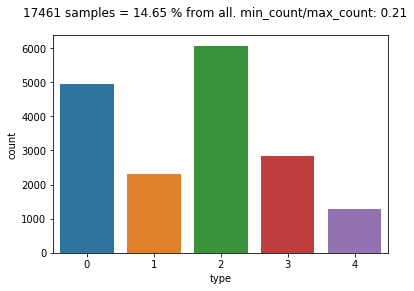

In [105]:
plotTypeDistribution(name_counts.keys()[validation_index_list])

This is good enough. The type classes are not necessary evenly spaced and this may explain why class 2 is the most common.

In [123]:
# Validation clusters
assert "Y" not in list(name_counts.keys()[validation_index_list])
_ = [print(name_counts.keys()[ind]) for ind in validation_index_list]

340.0
208.0
546.0
623.0
306.0
295.0
522.0
151.0
509.0
339.0
532.0
376.0
281.0
181.0
69.0
377.0
470.0
513.0
283.0
478.0
119.0
101.0
411.0
70.0
449.0
362.0
160.0
402.0
556.0
416.0
334.0
514.0
126.0
175.0
332.0
508.0
89.0
33.0
12.0
644.0
254.0
233.0
314.0
39.0
109.0
257.0
399.0
122.0
232.0
67.0
547.0
505.0
601.0
463.0
557.0
236.0
348.0
480.0
47.0
427.0
438.0
527.0
323.0
345.0
1.0
389.0
627.0
320.0
354.0
8.0
271.0
518.0
504.0
32.0
523.0
579.0
567.0
234.0
308.0
642.0
605.0
159.0
429.0
226.0
630.0
62.0
210.0
298.0
379.0
60.0
246.0
545.0
255.0
147.0
113.0
38.0
35.0
458.0
34.0
43.0
40.0
341.0
425.0
65.0
383.0
390.0
92.0
307.0
93.0
96.0
135.0
161.0
645.0
204.0
127.0
165.0
94.0
500.0
569.0
117.0
524.0
143.0
628.0
168.0
6.0
479.0
179.0
207.0
269.0
259.0
346.0
245.0
450.0
570.0
78.0
396.0
395.0
149.0
603.0
258.0
14.0
264.0
620.0
558.0
134.0
578.0
619.0
639.0
57.0
638.0
393.0
193.0
492.0
499.0
132.0
327.0
573.0
598.0
250.0
311.0


In [122]:
meta_tmp['isVal'] = np.where(meta_tmp.cluster_1.isin(list(name_counts.keys()[validation_index_list])),
                             True,
                             False)
meta_tmp.head()

,index,label,person_count,original,cluster_1,cluster_2,both_missing,first_person_label,second_person_label,name_index,isVal
0,gmuagvvcen.mp4,FAKE,1,xyioxposka.mp4,633.0,NaN,False,3.0,NaN,633.0,False
1,nlbejgudfx.mp4,FAKE,1,acguxjvmju.mp4,539.0,NaN,False,3.0,NaN,539.0,False
2,smptxlklxc.mp4,REAL,1,NaN,586.0,NaN,False,0.0,NaN,586.0,False
3,xmodyeeaxr.mp4,FAKE,1,ptpwappdyx.mp4,130.0,NaN,False,1.0,NaN,130.0,False
4,hvxrsfgvyi.mp4,FAKE,2,qelncdmypn.mp4,404.0,79.0,False,2.0,1.0,404.0,False


In [161]:
## Split the grouper into train and val using numpy's array_split
tmp_df = pd.DataFrame()
name_df = meta_tmp[~meta_tmp['name_index'].isin(["Y"])][['name_index', 'isVal']].drop_duplicates()
name_df = name_df.sample(frac=1, random_state=SEED)

train_df = name_df[name_df['isVal']==False]
val_df = name_df[name_df['isVal']==True]

for slice_df in [train_df, val_df]:
    for idx, df in enumerate(np.array_split(slice_df, NUM_FOLDS)):
        df['cv_fold'] = idx
        tmp_df = tmp_df.append(df)

Y_df = meta_tmp[meta_tmp['name_index']=="Y"][['name_index']].drop_duplicates()        
Y_df['isVal'] = True
Y_df['cv_fold'] = 999

tmp_df = tmp_df.append(Y_df)

meta_new = meta_tmp.merge(tmp_df[['name_index','cv_fold']], on='name_index', how='left')
meta_new['split'] = meta_new['isVal'].apply(lambda x: "2nd_level" if x else "1st_level")
meta_new['version'] = datetime.date.today()
meta_new = meta_new.drop_duplicates()

In [162]:
## Visualize the counts
tmp = meta_new.groupby(['split','cv_fold']).size().to_frame('counts')
tmp

counts
split     cv_fold        
1st_level 0         18624
          1         20216
          2         19981
          3         23945
          4         18472
          999         429
2nd_level 0          3839
          1          3204
          2          3860
          3          3244
          4          3340

In [163]:
## Check that we didn't violate any of the rules 
## A) all videos with same original must belong to exactly one cv_fold
assert meta_new.groupby(['name_index']).nunique()['cv_fold'].max()==1

## B) all videos with same cluster_1 must belong to exactly one cv_fold
assert meta_new[meta_new.cv_fold!=999].groupby(['cluster_1']).nunique()['cv_fold'].max()==1

## C) length of the new metadata must match the length of the original data
assert len(meta_new)==orig_len

In [164]:
for col in [None, 'original', 'cluster_1','cluster_2']:
    df = meta_new.copy()
    values = df[col] if col!=None else None
    aggfunc = 'count' if col!=None else None
    
    print("\ncounts wrt "+col if col!=None else "")
    
    display(pd.crosstab([df['split'], df['cv_fold']],
                        [df['split'], df['cv_fold']],
                        values, aggfunc=aggfunc
                       ).fillna(0), 
           )
    print("- "*40)

split             1st_level                                  2nd_level        \
cv_fold                 0      1      2      3      4    999       0     1     
split     cv_fold                                                              
1st_level 0           18624      0      0      0      0    0         0     0   
          1               0  20216      0      0      0    0         0     0   
          2               0      0  19981      0      0    0         0     0   
          3               0      0      0  23945      0    0         0     0   
          4               0      0      0      0  18472    0         0     0   
          999             0      0      0      0      0  429         0     0   
2nd_level 0               0      0      0      0      0    0      3839     0   
          1               0      0      0      0      0    0         0  3204   
          2               0      0      0      0      0    0         0     0   
          3               0      0      0      0      0    0         0     0   
          4               0      0      0      0      0    0         0     0   

split                                
cv_fold             2     3     4    
split     cv_fold                    
1st_level 0           0     0     0  
          1           0     0     0  
          2           0     0     0  
          3           0     0     0  
          4           0     0     0  
          999         0     0     0  
2nd_level 0           0     0     0  
          1           0     0     0  
          2        3860     0     0  
          3           0  3244     0  
          4           0     0  3340

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

counts wrt original


split             1st_level                                             \
cv_fold                 0        1        2        3        4      999   
split     cv_fold                                                        
1st_level 0         15786.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0  17009.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0  17198.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0  20795.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0  15767.0    0.0   
          999           0.0      0.0      0.0      0.0      0.0  374.0   
2nd_level 0             0.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0      0.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0      0.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0      0.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0      0.0    0.0   

split             2nd_level                                  
cv_fold                 0       1       2       3       4    
split     cv_fold                                            
1st_level 0             0.0     0.0     0.0     0.0     0.0  
          1             0.0     0.0     0.0     0.0     0.0  
          2             0.0     0.0     0.0     0.0     0.0  
          3             0.0     0.0     0.0     0.0     0.0  
          4             0.0     0.0     0.0     0.0     0.0  
          999           0.0     0.0     0.0     0.0     0.0  
2nd_level 0          2862.0     0.0     0.0     0.0     0.0  
          1             0.0  2508.0     0.0     0.0     0.0  
          2             0.0     0.0  2855.0     0.0     0.0  
          3             0.0     0.0     0.0  2474.0     0.0  
          4             0.0     0.0     0.0     0.0  2372.0

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

counts wrt cluster_1


split             1st_level                                             \
cv_fold                 0        1        2        3        4      999   
split     cv_fold                                                        
1st_level 0         18624.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0  20216.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0  19981.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0  23945.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0  18472.0    0.0   
          999           0.0      0.0      0.0      0.0      0.0  429.0   
2nd_level 0             0.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0      0.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0      0.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0      0.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0      0.0    0.0   

split             2nd_level                                  
cv_fold                 0       1       2       3       4    
split     cv_fold                                            
1st_level 0             0.0     0.0     0.0     0.0     0.0  
          1             0.0     0.0     0.0     0.0     0.0  
          2             0.0     0.0     0.0     0.0     0.0  
          3             0.0     0.0     0.0     0.0     0.0  
          4             0.0     0.0     0.0     0.0     0.0  
          999           0.0     0.0     0.0     0.0     0.0  
2nd_level 0          3839.0     0.0     0.0     0.0     0.0  
          1             0.0  3204.0     0.0     0.0     0.0  
          2             0.0     0.0  3860.0     0.0     0.0  
          3             0.0     0.0     0.0  3244.0     0.0  
          4             0.0     0.0     0.0     0.0  3340.0

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

counts wrt cluster_2


split             1st_level                                             \
cv_fold                 0        1        2        3        4      999   
split     cv_fold                                                        
1st_level 0         18624.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0  20216.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0  19981.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0  23945.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0  18472.0    0.0   
          999           0.0      0.0      0.0      0.0      0.0  429.0   
2nd_level 0             0.0      0.0      0.0      0.0      0.0    0.0   
          1             0.0      0.0      0.0      0.0      0.0    0.0   
          2             0.0      0.0      0.0      0.0      0.0    0.0   
          3             0.0      0.0      0.0      0.0      0.0    0.0   
          4             0.0      0.0      0.0      0.0      0.0    0.0   

split             2nd_level                                  
cv_fold                 0       1       2       3       4    
split     cv_fold                                            
1st_level 0             0.0     0.0     0.0     0.0     0.0  
          1             0.0     0.0     0.0     0.0     0.0  
          2             0.0     0.0     0.0     0.0     0.0  
          3             0.0     0.0     0.0     0.0     0.0  
          4             0.0     0.0     0.0     0.0     0.0  
          999           0.0     0.0     0.0     0.0     0.0  
2nd_level 0          3839.0     0.0     0.0     0.0     0.0  
          1             0.0  3204.0     0.0     0.0     0.0  
          2             0.0     0.0  3860.0     0.0     0.0  
          3             0.0     0.0     0.0  3244.0     0.0  
          4             0.0     0.0     0.0     0.0  3340.0

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [167]:
# update person count and merge classes
meta_new = meta_new.merge(fake_types_df[['index',
                                         'first_person_frame_labels',
                                         'second_person_frame_labels']], on='index')

# update person count
meta_new['person_count'] = np.where(fake_types_df['first_person_label'].isna(),
                                    0, # no persons
                                    np.where(fake_types_df['second_person_label'].isna(),
                                             1, # only first
                                             2)) # first and second
meta_new.head()

,index,label,person_count,original,cluster_1,cluster_2,both_missing,first_person_label,second_person_label,name_index,isVal,cv_fold,split,version,first_person_frame_labels,second_person_frame_labels
0,gmuagvvcen.mp4,FAKE,1,xyioxposka.mp4,633.0,-9.223372e+18,False,3.0,-9.223372e+18,633.0,False,3,1st_level,2020-02-17,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN
1,nlbejgudfx.mp4,FAKE,1,acguxjvmju.mp4,539.0,-9.223372e+18,False,3.0,-9.223372e+18,539.0,False,1,1st_level,2020-02-17,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN
2,smptxlklxc.mp4,REAL,1,None,586.0,-9.223372e+18,False,0.0,-9.223372e+18,586.0,False,0,1st_level,2020-02-17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
3,xmodyeeaxr.mp4,FAKE,1,ptpwappdyx.mp4,130.0,-9.223372e+18,False,1.0,-9.223372e+18,130.0,False,1,1st_level,2020-02-17,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
4,hvxrsfgvyi.mp4,FAKE,2,qelncdmypn.mp4,404.0,7.900000e+01,False,2.0,1.000000e+00,404.0,False,2,1st_level,2020-02-17,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."


In [168]:
## Save the splits
meta_new.sort_index(inplace=True)
meta_new = meta_new[KEEP_COLS]
meta_new.to_csv('../data/metadata_tr_val_split_folds.csv', index=False)

In [169]:
meta_new.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,-9.223372e+18,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,None,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,-9.223372e+18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,1.000000e+00,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


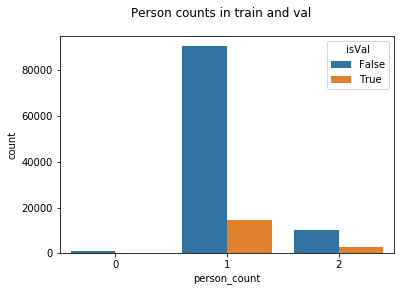

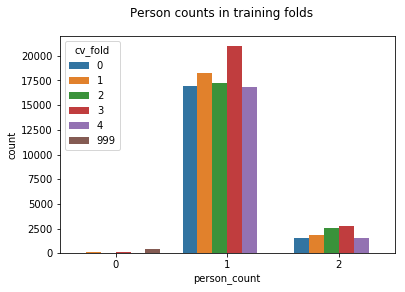

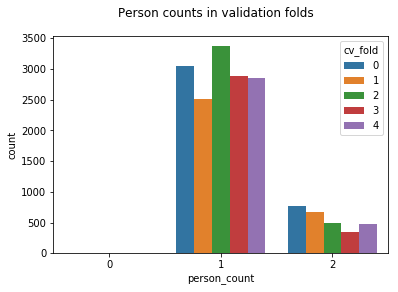

In [173]:
sns.countplot(x='person_count',hue='isVal',data=meta_new)
plt.suptitle('Person counts in train and val')
plt.show()

sns.countplot(x='person_count',hue='cv_fold',data=meta_new[meta_new['isVal']==False])
plt.suptitle('Person counts in training folds')
plt.show()

sns.countplot(x='person_count',hue='cv_fold',data=meta_new[meta_new['isVal']==True])
plt.suptitle('Person counts in validation folds')
plt.show()

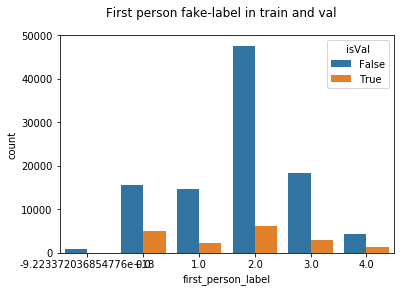

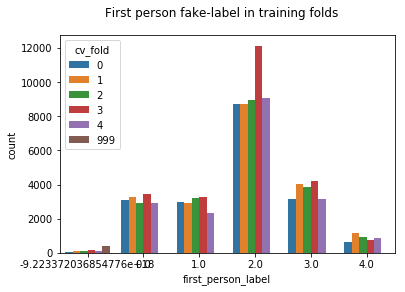

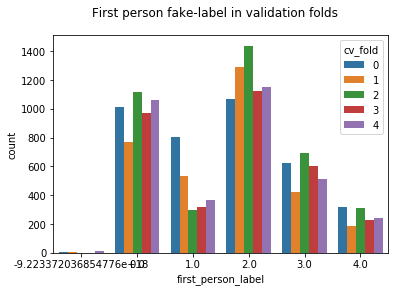

In [174]:
sns.countplot(x='first_person_label',hue='isVal',data=meta_new)
plt.suptitle('First person fake-label in train and val')
plt.show()

sns.countplot(x='first_person_label',hue='cv_fold',data=meta_new[meta_new['isVal']==False])
plt.suptitle('First person fake-label in training folds')
plt.show()

sns.countplot(x='first_person_label',hue='cv_fold',data=meta_new[meta_new['isVal']==True])
plt.suptitle('First person fake-label in validation folds')
plt.show()